In [2]:
import sys
sys.path.append("../")
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from axessettings import AxesSetting, linear_sim

In [3]:
data = pd.read_csv("./1-1-a.csv")
data["h"] = data["v2"] / data["v1"]
data["phase"] = (-data["frequency"] * data["t"] * 1e-9 * 360 + 180) % 360 - 180
print(data)


    frequency   v1     v2       t         h     phase
0        10.0  161   0.00     NaN  0.000000       NaN
1       100.0  163   0.00     NaN  0.000000       NaN
2      1000.0  162   0.00     NaN  0.000000       NaN
3     10000.0  162   0.00     NaN  0.000000       NaN
4     20000.0  162   0.00     NaN  0.000000       NaN
5     50000.0  168   0.60  6000.0  0.003571 -108.0000
6    100000.0  164   1.45  7600.0  0.008841   86.4000
7    200000.0  164   3.00 -1300.0  0.018293   93.6000
8    500000.0  162   9.00  -480.0  0.055556   86.4000
9    600000.0  162  11.70  -370.0  0.072222   79.9200
10   700000.0  160  16.00  -320.0  0.100000   80.6400
11   800000.0  160  23.00  -270.0  0.143750   77.7600
12   900000.0  156  34.00  -218.0  0.217949   70.6320
13   950000.0  154  45.50  -180.0  0.295455   61.5600
14   960000.0  152  48.20  -176.0  0.317105   60.8256
15   970000.0  151  51.10  -164.0  0.338411   57.2688
16   980000.0  151  54.40  -160.0  0.360265   56.4480
17   990000.0  149  57.70  -

In [4]:
def admittance_complex(w, R, L, C):
    return 1/(R + 1j * (w * L - 1 / (w * C)))

In [5]:
# C=470pF固定として、L, Rを最適化

admittance_abs = lambda f, R, L: abs(R * admittance_complex(2 * np.pi * f, R, L, 4.7e-10))
popt, pcov = curve_fit(admittance_abs, data["frequency"], data["h"], bounds=([20, 3e-5, 0], [100, 1e-4, 1]))
print(popt)
admittance_abs_theory = lambda f: admittance_abs(f, 30, 4.7e-5, 1)
admittance_abs_opt = lambda f: admittance_abs(f, *popt)

fig = plt.figure()
ax = fig.add_subplot(111)

axessetting = AxesSetting(title="|h(ω)|", xlim=(1e2, 4e+6), xscale="log", legend=True, xlabel="frequency [Hz]")

axessetting.plot_func(ax, admittance_abs_opt, label="fitted", alpha=0.6, c="lime")
axessetting.plot_func(ax, admittance_abs_theory, label="theoretical", alpha=0.3)
ax.scatter(data["frequency"], data["h"], s=4, c="red")
axessetting.apply_axes(ax)

TypeError: <lambda>() takes 3 positional arguments but 4 were given

In [ ]:
# Q value
y_cutoff = np.max(data["h"]) / np.sqrt(2)
f_peak = data.loc[data["h"].idxmax()]["frequency"]

tuplify = lambda x: (x["frequency"], x["h"])
# 17 & 18
f_min = linear_sim(tuplify(data.iloc[17]), tuplify(data.iloc[18]), y_cutoff)
#24 & 25
f_max = linear_sim(tuplify(data.iloc[24]), tuplify(data.iloc[25]), y_cutoff)

print(f"Calculated Q = {f_peak / (f_max - f_min): .2f}")

Calculated Q =  6.33


[4.32109487e+01 4.65202382e-05]


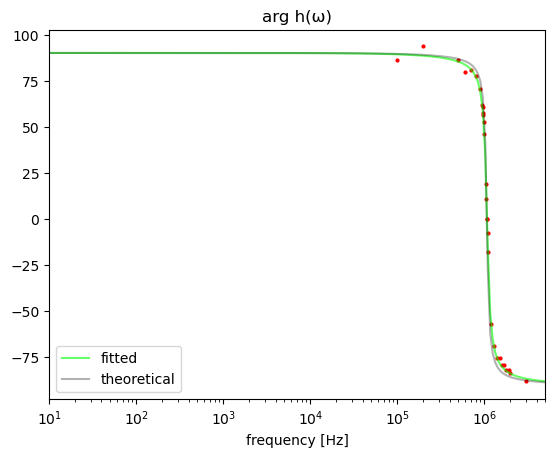

In [ ]:
# C=470pF固定として、L, Rを最適化
data_arg = data[["frequency", "phase"]].dropna().drop([5, 35])
admittance_arg = lambda f, R, L: np.angle(R * admittance_complex(2 * np.pi * f, R, L, 4.7e-10), deg=True)
popt, pcov = curve_fit(admittance_arg, data_arg["frequency"], data_arg["phase"], bounds=([20, 3e-5], [100, 7e-5]))
print(popt)
admittance_arg_theory = lambda f: admittance_arg(f, 30, 4.7e-5)
admittance_arg_opt = lambda f: admittance_arg(f, *popt)

fig = plt.figure()
ax = fig.add_subplot(111)

axessetting = AxesSetting(title="arg h(ω)", xlim=(1e1, 5e+6), xscale="log", legend=True, xlabel="frequency [Hz]")

axessetting.plot_func(ax, admittance_arg_opt, label="fitted", alpha=0.6, c="lime")
axessetting.plot_func(ax, admittance_arg_theory, label="theoretical", alpha=0.3)
ax.scatter(data_arg["frequency"], data_arg["phase"], s=4, c="red")
axessetting.apply_axes(ax)

In [ ]:
def step_response(t, V, C, L, R): #i
    a = R / (2 * L)
    b_inside = (R / (2*L)) ** 2 - 1/(L * C)
    if b_inside > 0:
        b = np.sqrt(b_inside)
        return V / (b * L) * np.exp(-a * t) * np.sinh(b * t) * R
    elif b_inside == 0:
        return V * t / L * np.exp(-a * t) * R
    else:
        beta = np.sqrt(-b_inside)
        return V / (beta * L) * np.exp(-a * t) * np.sin(beta * t) * R

#change v to v of step
step_response_theory_02 = lambda t: step_response(t, 0.047, 4.7e-10, 4.7e-5, 1.58e3)


 9.47e-02V


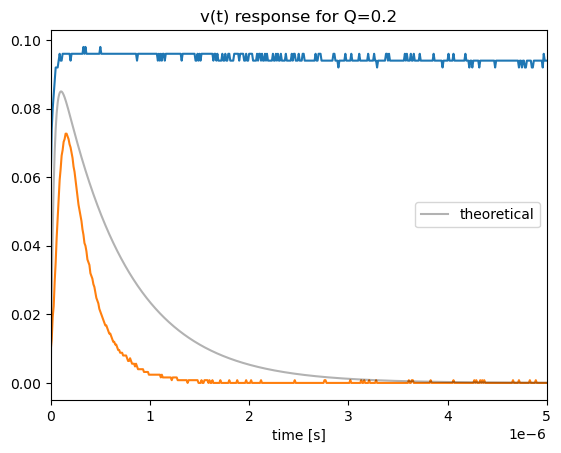

In [ ]:
# Q = 0.2

df_02 = pd.read_csv("q0_5.csv", skiprows=1)
df_02["Second"] += 0.05e-6
df_02["Volt"] -= np.min(df_02["Volt"])
v_02 = np.mean(df_02[df_02["Volt"] > 0.08]["Volt"])
print(f"{v_02: .2e}V")
step_response_theory_02 = lambda t: step_response(t, v_02, 4.7e-10, 4.7e-5, 1500)

#popt, pcov = curve_fit(step_response, df_05["Second"], df_05["Volt.1"], bounds=([0.05, 4e-10, 4e-5, 500], [5, 8e-10, 8e-5, 5000]))
#print(popt)


fig = plt.figure()
ax = fig.add_subplot(111)
axessetting = AxesSetting(title="v(t) response for Q=0.2", legend=True, xlabel="time [s]", xlim=(0, 0.5e-5))

ax.plot(df_02["Second"], df_02["Volt"])
ax.plot(df_02["Second"], df_02["Volt.1"])
# axessetting.plot_func(ax, lambda t: step_response(t, *popt), label="fitted", alpha=0.6, c="lime")
axessetting.plot_func(ax, lambda t: step_response_theory_02(t), label="theoretical", alpha=0.3, samplesize=1000)
# ax.scatter(df_step["frequency"], df_step["phase"], s=4, c="red")
axessetting.apply_axes(ax)

 9.47e-02V


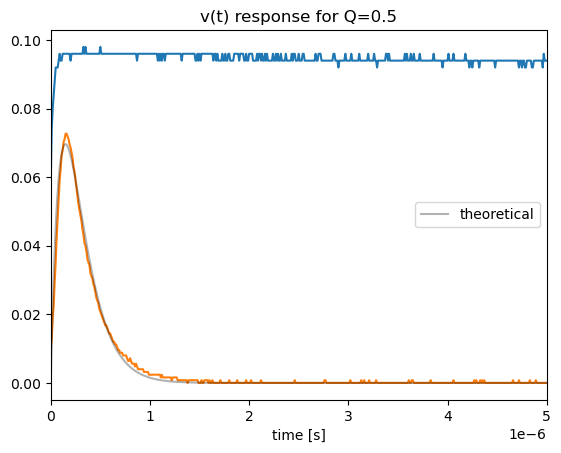

In [ ]:
# Q = 0.5

df_05 = pd.read_csv("q0_5.csv", skiprows=1)
df_05["Second"] += 0.05e-6
df_05["Volt"] -= np.min(df_05["Volt"])
v_05 = np.mean(df_05[df_05["Volt"] > 0.08]["Volt"])
print(f"{v_05: .2e}V")
step_response_theory_05 = lambda t: step_response(t, v_05, 4.7e-10, 4.7e-5, 632)

#popt, pcov = curve_fit(step_response, df_05["Second"], df_05["Volt.1"], bounds=([0.05, 4e-10, 4e-5, 500], [5, 8e-10, 8e-5, 5000]))
#print(popt)


fig = plt.figure()
ax = fig.add_subplot(111)
axessetting = AxesSetting(title="v(t) response for Q=0.5", legend=True, xlabel="time [s]", xlim=(0, 0.5e-5))

ax.plot(df_05["Second"], df_05["Volt"])
ax.plot(df_05["Second"], df_05["Volt.1"])
# axessetting.plot_func(ax, lambda t: step_response(t, *popt), label="fitted", alpha=0.6, c="lime")
axessetting.plot_func(ax, lambda t: step_response_theory_05(t), label="theoretical", alpha=0.3, samplesize=1000)
# ax.scatter(df_step["frequency"], df_step["phase"], s=4, c="red")
axessetting.apply_axes(ax)

 9.49e-02V


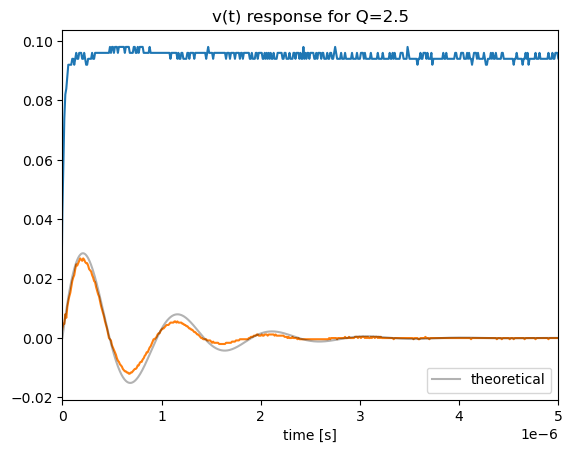

In [ ]:
# Q = 2.5

df_25 = pd.read_csv("q2_5.csv", skiprows=1)
df_25["Second"] += 0.06e-6
df_25["Volt"] -= np.min(df_25["Volt"])
v_25 = np.mean(df_25[df_25["Volt"] > 0.08]["Volt"])
print(f"{v_25: .2e}V")
step_response_theory_25 = lambda t: step_response(t, v_25, 4.7e-10, 4.7e-5, 125.6)

fig = plt.figure()
ax = fig.add_subplot(111)
axessetting = AxesSetting(title="v(t) response for Q=2.5", legend=True, xlabel="time [s]", xlim=(0, 0.5e-5))

ax.plot(df_25["Second"], df_25["Volt"])
ax.plot(df_25["Second"], df_25["Volt.1"])
# axessetting.plot_func(ax, admittance_arg_opt, label="fitted", alpha=0.6, c="lime")
axessetting.plot_func(ax, lambda t: step_response_theory_25(t), label="theoretical", alpha=0.3, samplesize=1000)
# ax.scatter(df_step["frequency"], df_step["phase"], s=4, c="red")
axessetting.apply_axes(ax)

 9.49e-02V


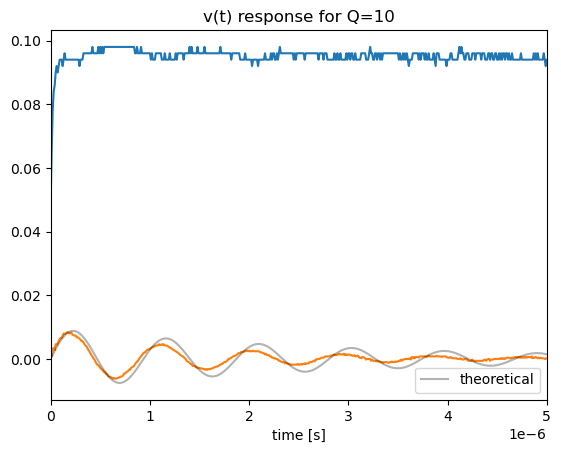

In [ ]:
# Q = 10

df_10 = pd.read_csv("q0wFile0.csv", skiprows=1)
df_10["Second"] += 0.06e-6
df_10["Volt"] -= np.min(df_10["Volt"])
v_10 = np.mean(df_10[df_10["Volt"] > 0.08]["Volt"])
print(f"{v_25: .2e}V")
step_response_theory_10 = lambda t: step_response(t, v_10, 4.7e-10, 4.7e-5, 31.6)

fig = plt.figure()
ax = fig.add_subplot(111)
axessetting = AxesSetting(title="v(t) response for Q=10", legend=True, xlabel="time [s]", xlim=(0, 0.5e-5))

ax.plot(df_10["Second"], df_10["Volt"])
ax.plot(df_10["Second"], df_10["Volt.1"])
# axessetting.plot_func(ax, admittance_arg_opt, label="fitted", alpha=0.6, c="lime")
axessetting.plot_func(ax, lambda t: step_response_theory_10(t), label="theoretical", alpha=0.3, samplesize=1000)
# ax.scatter(df_step["frequency"], df_step["phase"], s=4, c="red")
axessetting.apply_axes(ax)

Q =  10.04
 9.30e-02V


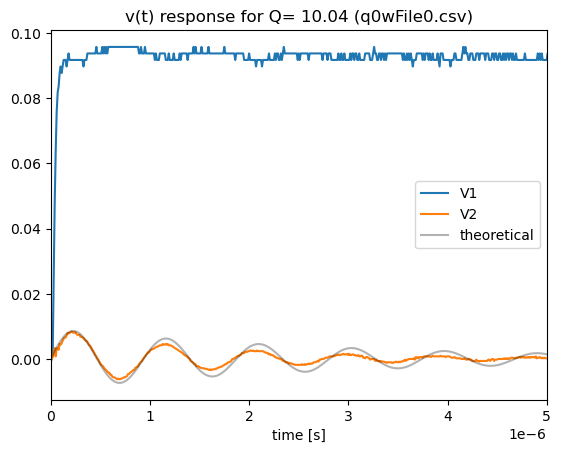

In [ ]:
#ここに数値を入力
R_used = 31.5
fname = "q0wFile0.csv"
delay = 0.1e-6

df_read = pd.read_csv(fname, skiprows=[1])
Q = np.sqrt(4.7e-5/4.7e-10) / R_used
print(f"Q = {Q: .2f}")
df_read["X"] += delay
df_read["CH1"] -= np.mean(df_read[df_read["CH1"] < 0]["CH1"])
v_read = np.mean(df_read[df_read["CH1"] > 0.08]["CH1"])
print(f"{v_read: .2e}V")
step_response_theory_read = lambda t: step_response(t, v_read, 4.7e-10, 4.7e-5, R_used)

#popt, pcov = curve_fit(step_response, df_05["Second"], df_05["Volt.1"], bounds=([0.05, 4e-10, 4e-5, 500], [5, 8e-10, 8e-5, 5000]))
#print(popt)


fig = plt.figure()
ax = fig.add_subplot(111)
axessetting = AxesSetting(title=f"v(t) response for Q={Q: .2f} ({fname})", legend=True, xlabel="time [s]", xlim=(0, 0.5e-5))

ax.plot(df_read["X"], df_read["CH1"], label="V1")
ax.plot(df_read["X"], df_read["CH2"], label="V2")
# axessetting.plot_func(ax, lambda t: step_response(t, *popt), label="fitted", alpha=0.6, c="lime")
axessetting.plot_func(ax, step_response_theory_read, label="theoretical", alpha=0.3, samplesize=1000)
# ax.scatter(df_step["frequency"], df_step["phase"], s=4, c="red")
axessetting.apply_axes(ax)

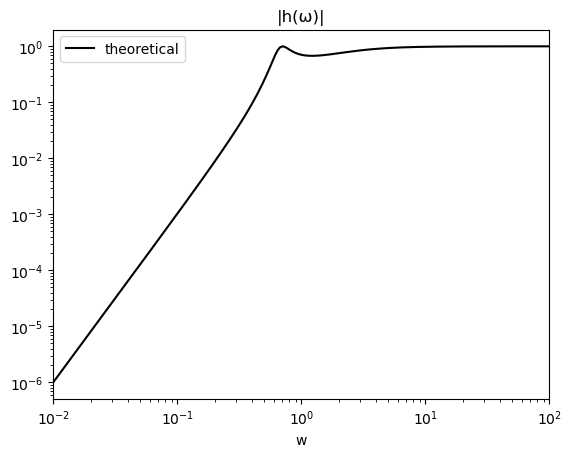

In [ ]:
def dentatsu(s, L, C1, C2):
    return (L * C1 * C2 * s**3) / (L * C1 * C2 * s**3 + L * (C1+C2) * s**2 + 1)

d_f = lambda w, L, C1, C2: dentatsu(1j * w, L, C1, C2)

fig = plt.figure()
ax = fig.add_subplot(111)

axessetting = AxesSetting(title="|h(ω)|", xlim=(1e-2, 1e2), xscale="log", legend=True, xlabel="w", yscale="log")

axessetting.plot_func(ax, lambda w: abs(d_f(w, 1, 1, 1)), label="theoretical", alpha=1)
#ax.scatter(data["frequency"], data["h"], s=4, c="red")
axessetting.apply_axes(ax)

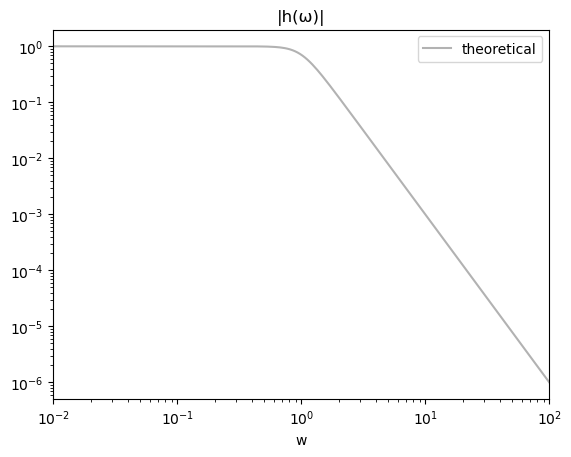

In [8]:
def f_lpf(s, L1, L2, C):
    return 1/(L1*L2*C*s**3 + L1*C*s**2 + (L1+L2)*s + 1)


fig = plt.figure()
ax = fig.add_subplot(111)

axessetting = AxesSetting(title="|h(ω)|", xlim=(1e-2, 1e2), xscale="log", legend=True, xlabel="w", yscale="log")

axessetting.plot_func(ax, lambda w: abs(f_lpf(1j*w, 1.5, 0.5, 4/3)), label="theoretical", alpha=0.3)
#ax.scatter(data["frequency"], data["h"], s=4, c="red")
axessetting.apply_axes(ax)